# Machine Learning Group Project 2023
 Ashkan Lotfollahzadeh (ashka.lotfollahzadeh@studio.unibo.it) - Michelle Lee Kruschke (michellelee.kruschke@studio.unibo.it) - Marco Mancuso Morini (marco.mancusomorini@studio.unibo.it) - Melissa Nieto Ridoutt (melissa.nietoridoutt@studio.unibo.it) - João Victor Pereira Dos Santos (joao.pereirados2@studio.unibo.it)



## Introduction

We chose the Kaggle competition <https://www.kaggle.com/competitions/instacart-market-basket-analysis>.  Instacart is an American company that offers grocery shopping and delivery services via website and a moblie app. It connects users with a personal shopper in their area to shop and deliver groceries from local participating stores. Although the original objective of the competition was quite complex, we chose to evalute the problem lookiing at the whether a product would be reordered based on various features of past history, and additionally a Market Basket Analysis to determine which prodoucts could possibly be purchased together in the future. The datasets used in the evaluation were provided in 2017, by Instacart, in open sourced data taken from over 200,000 Instacart users.

In [7]:
#Importing libraries:

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from xgboost import XGBClassifier
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from sklearn.preprocessing import MinMaxScaler


In [8]:
#Creating relevant variables
rs = 42 #Random_state
np.random.seed(rs)
cv = 3
%matplotlib inline


In [9]:
aisles=pd.read_csv('aisles.csv')
departments=pd.read_csv('departments.csv')
products=pd.read_csv('products.csv')
orders=pd.read_csv('orders.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')


## 0. Analysing the data

### Aisles

In [10]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
aisles.shape, len(aisles['aisle_id'].unique())

((134, 2), 134)

In [12]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


## Departments

In [13]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [14]:
departments.shape, len(departments['department_id'].unique())

((21, 2), 21)

In [15]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


### Products

In [16]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [17]:
products.shape, len(products['product_id'].unique())

((49688, 4), 49688)

In [18]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


### Orders

In [19]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [20]:
orders.shape, len(orders['order_id'].unique())

((3421083, 7), 3421083)

In [21]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

### Order_Products_Prior  

In [22]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [23]:
order_products_prior.shape, len(order_products_prior['order_id'].unique())

((32434489, 4), 3214874)

In [24]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


### Order_Products_Train

In [25]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [26]:
order_products_train.shape, len(order_products_train['order_id'].unique())

((1384617, 4), 131209)

In [27]:
order_products_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


## 1. Merging the data

In [28]:
#Creating a unified product dataframe
products=pd.merge(products, aisles, on='aisle_id')
products=pd.merge(products, departments, on='department_id')

In [29]:
#Concating the orders_products train and prior df's:
order_prod_pt = pd.concat([order_products_prior, order_products_train])

In [30]:
#Merging the new df with the prior and train data with the order df:
full_orders_df=pd.merge(orders, order_prod_pt, on='order_id')

In [31]:
#Final dataframe with all datasets merged
df=pd.merge(full_orders_df, products, on='product_id')

In [32]:
df.head(25)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196,1,0,Soda,77,7,soft drinks,beverages
1,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,soft drinks,beverages
2,473747,1,prior,3,3,12,21.0,196,1,1,Soda,77,7,soft drinks,beverages
3,2254736,1,prior,4,4,7,29.0,196,1,1,Soda,77,7,soft drinks,beverages
4,431534,1,prior,5,4,15,28.0,196,1,1,Soda,77,7,soft drinks,beverages
5,3367565,1,prior,6,2,7,19.0,196,1,1,Soda,77,7,soft drinks,beverages
6,550135,1,prior,7,1,9,20.0,196,1,1,Soda,77,7,soft drinks,beverages
7,3108588,1,prior,8,1,14,14.0,196,2,1,Soda,77,7,soft drinks,beverages
8,2295261,1,prior,9,1,16,0.0,196,4,1,Soda,77,7,soft drinks,beverages
9,2550362,1,prior,10,4,8,30.0,196,1,1,Soda,77,7,soft drinks,beverages


In [33]:
df.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
count,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.174104e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07,3.381911e+07
mean,1.710566e+06,1.029444e+05,1.713998e+01,2.737285e+00,1.343123e+01,1.136415e+01,2.557551e+04,8.367738e+00,5.900617e-01,7.121799e+01,9.918544e+00
std,9.874008e+05,5.946733e+04,1.749829e+01,2.093296e+00,4.246149e+00,8.940500e+00,1.409770e+04,7.139540e+00,4.918220e-01,3.819898e+01,6.281655e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,8.554130e+05,5.143500e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00,1.351900e+04,3.000000e+00,0.000000e+00,3.100000e+01,4.000000e+00
50%,1.710660e+06,1.026260e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00,2.525600e+04,6.000000e+00,1.000000e+00,8.300000e+01,9.000000e+00
75%,2.565587e+06,1.544120e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01,3.793500e+04,1.100000e+01,1.000000e+00,1.070000e+02,1.600000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,4.968800e+04,1.450000e+02,1.000000e+00,1.340000e+02,2.100000e+01


## 2. Data Cleaning

In [34]:
#Seeing the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_id              int64  
 8   add_to_cart_order       int64  
 9   reordered               int64  
 10  product_name            object 
 11  aisle_id                int64  
 12  department_id           int64  
 13  aisle                   object 
 14  department              object 
dtypes: float64(1), int64(10), object(4)
memory usage: 4.0+ GB


In [35]:
#Seeing if we have null values:
df.isna().sum()

order_id                        0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [36]:
#filling nulls with the days_since_prior_order per product mean
df['days_since_prior_order']=df['days_since_prior_order'].fillna(df.groupby('product_id')['days_since_prior_order'].transform('mean'))

In [37]:
#verify the new mean and compare above. The raw indexed as 0 had null values in the days_since_prior_order column
y=df.groupby('product_id', as_index=False)['days_since_prior_order'].mean()
print(y['days_since_prior_order'].loc[y['product_id']==196]==df['days_since_prior_order'].iloc[0])


195    True
Name: days_since_prior_order, dtype: bool


In [38]:
#Seeing if we have null values:
df.isna().sum()

order_id                   0
user_id                    0
eval_set                   0
order_number               0
order_dow                  0
order_hour_of_day          0
days_since_prior_order    40
product_id                 0
add_to_cart_order          0
reordered                  0
product_name               0
aisle_id                   0
department_id              0
aisle                      0
department                 0
dtype: int64

In [39]:
#we are accepting 40 value=0, it is a particular product but it represents only 0.000001182% of the dataset
df['days_since_prior_order']=df['days_since_prior_order'].fillna(0)
df.isna().sum() 

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_id                0
add_to_cart_order         0
reordered                 0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64

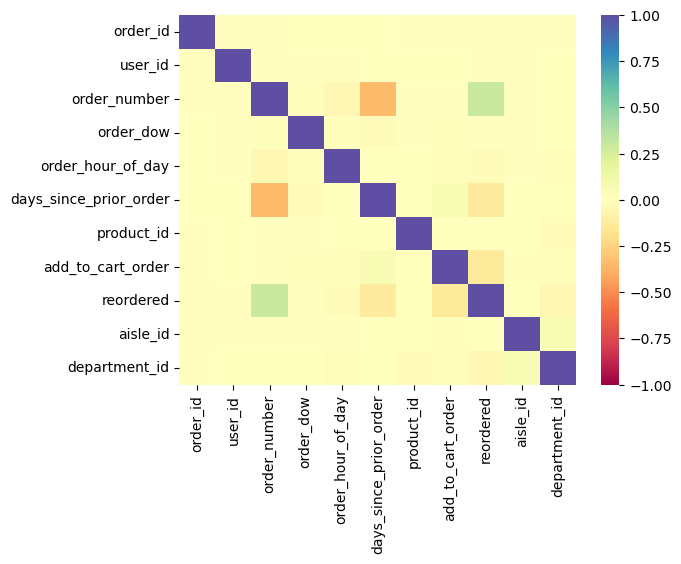

In [40]:
# Graph shows little or no correlation between features
sns.heatmap(df.corr(), annot=False, cmap='Spectral', vmin=-1, vmax=1)
plt.show()

## 3. Reduced Dataset

### 3.1. Getting a random sample of the dataframe

We need to sample the DataFrame before dividing it into train and validation to be sure that part of the train data is not randomly selected into the validation data.

In [41]:
# Creating the prior DF so we can divide it:
df_prior = df[df['eval_set'] == 'prior']

In [36]:
# -------------------------- Samplying the data by user' -------------------------------

'''
Here it will sample X user_ids and the number of rows would be the sum of the rows of the 
users selected
'''
user_ids_to_sample = list(df_prior['user_id'].sample(300, random_state=rs))

# filter the dataframe to only contain rows with the selected order_ids
prior_red = df_prior[df_prior['user_id'].isin(user_ids_to_sample)]


In [37]:
prior_red.shape, prior_red['user_id'].nunique()

((134610, 15), 300)

In [38]:
#dropping columns that we fill that are not important as the others:
prior_red.drop(columns=['order_id', 'user_id','aisle_id', 'department_id','product_id', 'aisle', 'product_name', 'department'], axis=1, inplace=True)

### 3.2. Dividing the dataset into 3 (divide the dataset into 3 using the eval_set column:

- Prior --> Train
- Train --> Validation
- Test --> Test

In [39]:
#Dividing the new prior df reduced into train and validation:
train_data, val_data = train_test_split(prior_red, test_size=0.2)

In [40]:
#Test dataset:
df_test = df[df['eval_set'] == 'train'].iloc[0:13696]

Dropping the <i>eval_set</i> column

Makes no sense to maintain the eval column after the division, so we dropt it.

In [41]:
train_data.drop(['eval_set'], axis=1, inplace=True);

In [42]:
val_data.drop(['eval_set'], axis=1, inplace=True)

In [43]:
df_test.drop(columns=['eval_set', 'order_id', 'user_id','product_id', 'aisle', 'product_name', 'department', 'aisle_id', 'department_id'], axis=1, inplace=True);

In [44]:
train_data.shape, val_data.shape

((107688, 6), (26922, 6))

In [45]:
df_test.shape

(13696, 6)

#### Dealing with NANs

In [46]:
train_data.isna().sum()

order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
add_to_cart_order         0
reordered                 0
dtype: int64

In [47]:
val_data.isna().sum()

order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
add_to_cart_order         0
reordered                 0
dtype: int64

## 4. Baseline Model

### 4.1. Data Visualization

#### Does our sampled data replicate the data distribution of the complete data?

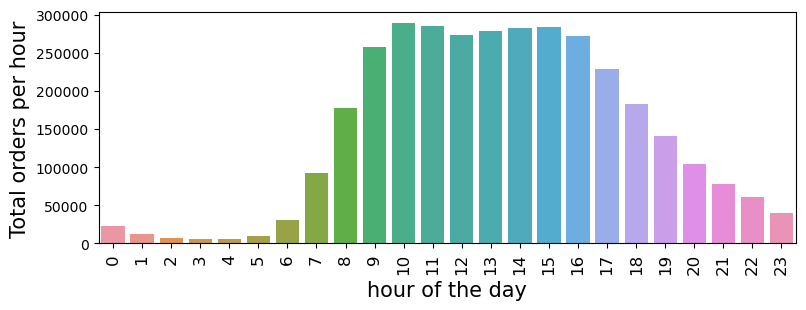

In [48]:
#order_hour_of_day distribution from the original orders:
orders_hour = orders.groupby('order_hour_of_day')['order_number'].count().to_frame('number_of_orders_each_hour')
plt.figure(figsize=(9,3))
sns.barplot(orders_hour.index, orders_hour.number_of_orders_each_hour, order=orders_hour.index)
plt.xlabel('hour of the day', size=15)
plt.ylabel('Total orders per hour', size=15)
plt.xticks(size=12, rotation=90)
plt.show();

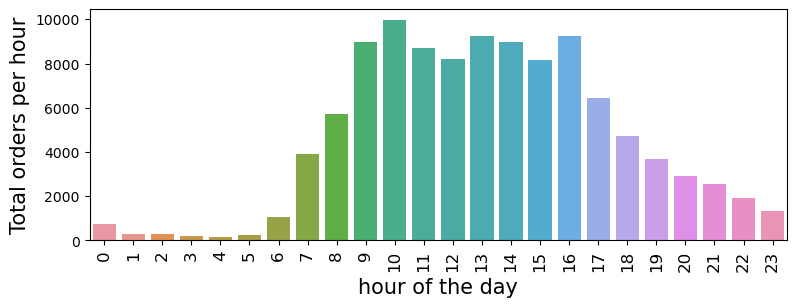

In [49]:
#order_hour_of_day distribution from the train data (sampled):
train_hour = train_data.groupby('order_hour_of_day')['order_number'].count().to_frame('number_of_orders_each_hour')
plt.figure(figsize=(9,3))
sns.barplot(train_hour.index, train_hour.number_of_orders_each_hour, order=train_hour.index)
plt.xlabel('hour of the day', size=15)
plt.ylabel('Total orders per hour', size=15)
plt.xticks(size=12, rotation=90)
plt.show();

As both graphs look very similar we concluded that our random samplying replicates pretty well the overall distribution and proportion of the orginal data.

### 4.2. Preprocessing

In [50]:
train_data['days_since_prior_order'] = train_data['days_since_prior_order'].astype('int8')

In [51]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107688 entries, 25185383 to 30213723
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   order_number            107688 non-null  int64
 1   order_dow               107688 non-null  int64
 2   order_hour_of_day       107688 non-null  int64
 3   days_since_prior_order  107688 non-null  int8 
 4   add_to_cart_order       107688 non-null  int64
 5   reordered               107688 non-null  int64
dtypes: int64(5), int8(1)
memory usage: 5.0 MB


In [52]:
train_data.columns

Index(['order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'add_to_cart_order', 'reordered'],
      dtype='object')

### 4.3. Splitting the data into the predicting values ​​X and the class y 

In [53]:
#Spliting the train data:
X_train = train_data.drop('reordered', axis=1)
y_train = train_data['reordered']

#Splitting the validation data:
X_val = val_data.drop('reordered', axis=1)
y_val = val_data['reordered']

#Splitting the Test data:
X_test = df_test.drop('reordered', axis=1)
y_test = df_test['reordered']

In [54]:
#Preprocessing this Data:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### 4.4. Running Models

#### 4.4.1 Decision Tree Model

We know that a decision tree is too simple of a model, but we wanted to begin with the simplest one before trying random forest and XGBoost.

In [55]:
#Creating and fitting the Decision Tree model:
model_tree = DecisionTreeClassifier(criterion="entropy", random_state = rs)
model_tree.fit(X_train, y_train);

In [56]:
#Predicting:
y_tree = model_tree.predict(X_val)

#Seeing the accuracy:
accuracy_ho = accuracy_score(y_val, y_tree) * 100

#Understanding the max_depth and preparing a varible for a loop validation:
max_depth = model_tree.tree_.max_depth
parameter_values = range(1,max_depth+1)

print("The accuracy on test set is {0:.1f}%".format(accuracy_ho))
print("The maximum depth of the tree fitted on X_train is {}".format(max_depth))

The accuracy on test set is 72.9%
The maximum depth of the tree fitted on X_train is 38


	--------------------------------- Observation ---------------------------------
    
    We were surprised by the accuracy of the Decision Tree Classifier. Maybe this is not a complex problem as we thought. Maybe the other more complex models will tend to overfit. Still, we will try them anyway. But first let's try to improve de Decision Tree model a little bit more.
    
	-------------------------------------------------------------------------------

In [57]:
avg_scores = []
for par in parameter_values:
    estimator = DecisionTreeClassifier(criterion="entropy"
                                            , max_depth = par
                                            , random_state = rs
                                            )
    scores = cross_val_score(estimator, X_train, y_train
                             , scoring='accuracy', cv = cv)
    # cross_val_score produces an array with one score for each fold
    avg_scores.append(np.mean(scores))
print(avg_scores)

[0.7499628556570834, 0.7499628556570834, 0.7520615110318699, 0.7559616670381102, 0.7568624173538371, 0.7575774459549812, 0.7574845850976896, 0.7568345590966495, 0.7580138919842508, 0.7575495876977936, 0.7576053042121685, 0.757577445954981, 0.7563888269816507, 0.7540115890349899, 0.7503342990862492, 0.7475577594532353, 0.7443819181338682, 0.7409739246712724, 0.7364516009211797, 0.732393581457544, 0.729552039224426, 0.7276391055642226, 0.7252897258747493, 0.7219931654409034, 0.7199130822375753, 0.7196159274942427, 0.7186780328355992, 0.7179630042344551, 0.7191701953792439, 0.7190494762647649, 0.7186223163212242, 0.7189844736646608, 0.7185851719783077, 0.7187987519500779, 0.7188173241215363, 0.7189751875789318, 0.7188916128073695, 0.7188916128073695]


In [58]:
top_par_cv = parameter_values[np.argmax(avg_scores)]
estimator_best = DecisionTreeClassifier(criterion="entropy", max_depth = top_par_cv, random_state=rs)
estimator_best.fit(X_train,y_train);
y_predicted = estimator_best.predict(X_test)
accuracy_cv = accuracy_score(y_test, y_predicted) * 100
print("The accuracy on test set tuned with cross_validation is {:.1f}% with depth {}".format(accuracy_cv, top_par_cv))

The accuracy on test set tuned with cross_validation is 82.1% with depth 9


In [59]:
#Classitication Report on the DT model:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.34      0.19      0.24      2075
           1       0.87      0.93      0.90     11621

    accuracy                           0.82     13696
   macro avg       0.60      0.56      0.57     13696
weighted avg       0.79      0.82      0.80     13696



In [60]:
#Confusion matrix in the DT model:
tree_matrix = confusion_matrix(y_test, y_predicted)

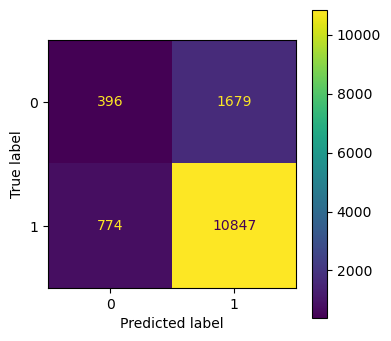

In [61]:
#Plotting the Confusion Matrix in a more vivid and clear way:
plt.rcParams['figure.figsize'] = [4, 4]
disp_tree = ConfusionMatrixDisplay(confusion_matrix=tree_matrix,
                 display_labels=estimator_best.classes_);
disp_tree.plot();

### 4.5. Fine Tunning

#### 4.5.1. RandomSearchCV

We saw that our simple model was overffiting so we decided to limit the max_depth paramter between 10 to 21. ALso, we decided for the RandomSearchCV instead of the GridSearch because the RandomSearchCV oud impose less computational power.

In [62]:
#Definning our models and the params that we will try for each of them:
model_lbls = ['dt' # decision tree
             ,'xgb' # XGBoost
             ,'rf' # Random Forest
             ,'knn' #KNN classifier
            ]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=rs), 
           'param': [{'criterion': ['gini', 'entropy']
                      , 'min_samples_split': [*range(1,10)]
                      , 'max_depth': [*range(1,max_depth+1)]
                      , 'class_weight':[None,'balanced']
                      , 'min_samples_leaf': [*range(1,10)]
          }]},
    
    'xgb':{'name': 'XGBoost           ',
           'estimator': XGBClassifier(random_state=rs),
           'param': [{'n_estimators':[10, 20, 30, 40 ],
                     'learning_rate':[0.001, 0.005, 0.01],
                     'n_jobs': [None, -1]
          }]},
    
    'rf': {'name': 'Random Forest       ',
           'estimator': RandomForestClassifier(random_state=rs),
           'param': [{'criterion': ['gini', 'entropy']
                     ,'max_depth': [*range(4,max_depth+1)]
                     ,'n_estimators':[*range(10,60,10)]
                     ,'min_samples_leaf': [*range(1,10)]
                     ,'min_samples_split': [*range(1,10)]
          }]}, 
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': [2],
                      'weights' : ['uniform', 'distance'],
                      'metric': ['euclidean', 'manhattan', 'cityblock'],
           }]}
}

In [63]:
scorings = ['accuracy','precision_macro','recall_macro','f1_macro']

In [64]:
#Running a GridSearch for each model and each different combination of params:
clfs = []
my_models = pd.DataFrame(columns=['scoring','model','best_params','accuracy','precision_macro',
                                  'recall_macro','f1_macro'])
for model in model_lbls:
    for scoring in scorings:
        clf = RandomizedSearchCV(models[model]['estimator'], models[model]['param'], cv=cv,
                           scoring = scoring, n_jobs=-1, n_iter=200, verbose=2
                           )
        #Appending the clfs list with each clf fit
        clf.fit(X_train, y_train)
        clfs.append(clf)
        
        #creating the accuracy variable
        y_pred = clf.predict(X_val)
        accuracy = accuracy_score(y_val,y_pred)
        
        
        cr = classification_report(y_val,y_pred, output_dict=True)
        
        #creating the precision_macro variable
        precision_macro = precision_score(y_val, y_pred, average='macro')
        
        #creating the recall_macro variable
        recall_macro = recall_score(y_val, y_pred, average='macro')
        
        #creating the f1_macro variable
        f1_macro = f1_score(y_val, y_pred, average='macro')
        
        best_params = clf.best_params_
        
        #Appending the dataset row by row
        row = [scoring, model, best_params, accuracy, precision_macro, recall_macro, f1_macro]
        my_models.loc[len(my_models)] = row
        

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [65]:
#Plotting our models dataframe:
my_models

,scoring,model,best_params,accuracy,precision_macro,recall_macro,f1_macro
0,accuracy,dt,"{'min_samples_split': 2, 'min_samples_leaf': 2...",0.758042,0.719503,0.645197,0.658558
1,precision_macro,dt,"{'min_samples_split': 6, 'min_samples_leaf': 2...",0.756222,0.726250,0.630649,0.641953
2,recall_macro,dt,"{'min_samples_split': 3, 'min_samples_leaf': 2...",0.704257,0.665862,0.688617,0.670509
3,f1_macro,dt,"{'min_samples_split': 3, 'min_samples_leaf': 3...",0.751430,0.698781,0.677464,0.685452
4,accuracy,xgb,"{'n_jobs': None, 'n_estimators': 40, 'learning...",0.757410,0.734108,0.627439,0.637984
5,precision_macro,xgb,"{'n_jobs': None, 'n_estimators': 30, 'learning...",0.758116,0.736356,0.627757,0.638369
6,recall_macro,xgb,"{'n_jobs': None, 'n_estimators': 40, 'learning...",0.757410,0.734108,0.627439,0.637984
7,f1_macro,xgb,"{'n_jobs': None, 'n_estimators': 40, 'learning...",0.757410,0.734108,0.627439,0.637984
8,accuracy,rf,"{'n_estimators': 40, 'min_samples_split': 8, '...",0.783857,0.758353,0.684369,0.702399
9,precision_macro,rf,"{'n_estimators': 30, 'min_samples_split': 5, '...",0.752842,0.764583,0.600422,0.599991


In [66]:
#Seeing our best model for each score type:

print("Best Accuracy model is {} using this best parameters: {}.".format(my_models['model'].loc[my_models['accuracy'].argmax()], 
                                                                        my_models['best_params'].loc[my_models['accuracy'].argmax()]))
print('-'*90)

print("Best Precision model is {} using this best parameters: {}.".format(my_models['model'].loc[my_models['precision_macro'].argmax()], 
                                                                        my_models['best_params'].loc[my_models['precision_macro'].argmax()]))
print('-'*90)

print("Best Recall model is {} using this best parameters: {}.".format(my_models['model'].loc[my_models['recall_macro'].argmax()], 
                                                                        my_models['best_params'].loc[my_models['recall_macro'].argmax()]))
print('-'*90)

print("Best F1 model is {} using this best parameters: {}.".format(my_models['model'].loc[my_models['f1_macro'].argmax()], 
                                                                        my_models['best_params'].loc[my_models['f1_macro'].argmax()]))


Best Accuracy model is rf using this best parameters: {'n_estimators': 40, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 32, 'criterion': 'entropy'}.
------------------------------------------------------------------------------------------
Best Precision model is rf using this best parameters: {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_depth': 4, 'criterion': 'entropy'}.
------------------------------------------------------------------------------------------
Best Recall model is knn using this best parameters: {'weights': 'uniform', 'n_neighbors': 2, 'metric': 'manhattan'}.
------------------------------------------------------------------------------------------
Best F1 model is knn using this best parameters: {'weights': 'distance', 'n_neighbors': 2, 'metric': 'manhattan'}.


	--------------------------------- Observation ---------------------------------
    
It seems that our model is overfiting, because it is always running with the same efficiency no matter the parameters. What we could do here is to test our models with a new data that it never saw before to see how well it can reproduce its scoring results. Also, we could try the early stopping with the XGBClassifier. 

	-------------------------------------------------------------------------------

### 4.6. Testing the best model

Testing the best model to see if it can reproduce the same accuracy, precision, etc.

#### 4.6.1. Random Forest (The Theoretically Best model)

In [67]:
best_model = RandomForestClassifier(criterion="entropy", 
                                    random_state = rs, 
                                    max_depth = 32, 
                                    n_estimators=40,
                                    min_samples_split=8,
                                    min_samples_leaf=1)
best_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=32, min_samples_split=8,
                       n_estimators=40, random_state=42)

In [68]:
#Predicting:
y_best = best_model.predict(X_test)

#Seeing the accuracy:
accuracy_best = accuracy_score(y_test, y_best) * 100

#creating the precision_macro variable
precision_best = precision_score(y_test, y_best, average='macro') * 100

#creating the recall_macro variable
recall_best = recall_score(y_test, y_best, average='macro') * 100

#creating the f1_macro variable
f1_best = f1_score(y_test, y_best, average='macro')* 100

print("The accuracy on test set is {0:.1f}%".format(accuracy_best)) 


The accuracy on test set is 80.4%


In [69]:
#Classitication Report on the RF model:
print(classification_report(y_test, y_best))

              precision    recall  f1-score   support

           0       0.31      0.24      0.27      2075
           1       0.87      0.90      0.89     11621

    accuracy                           0.80     13696
   macro avg       0.59      0.57      0.58     13696
weighted avg       0.79      0.80      0.79     13696



In [70]:
print(confusion_matrix(y_test, y_best))

[[  502  1573]
 [ 1109 10512]]


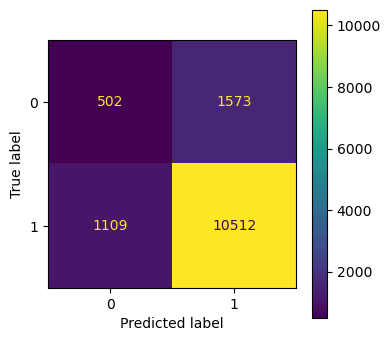

In [71]:
#Plotting the Confusion Matrix in a more vivid and clear way:
plt.rcParams['figure.figsize'] = [4, 4]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_best),
                 display_labels=best_model.classes_);
disp.plot();

	--------------------------------- Conclusion ---------------------------------
    
Our models seems to be overfiting a little when running our Train and Validation data, but when running in an entire new data, like the teste dataframe, it is still has a good accuracy of more then 60%, which in the real world can be a good metric. Also, the Random Forest model could reproduce the results better than the other two. Furthermore, this "best model" has a great recall and a "ok" precision when predicting if we'll have a reorder or not which is what we want. The same cannot be said about the precision and recall of this model when predicts a "not reorder". 

We also think that maybe with more data (instead of the sample) we could have a model that reproduces its results even better, but our notebook are not powerful enough to run all the codes with the whole dataset.

	-------------------------------------------------------------------------------

### Market Basket Analysis Association and Column creation

We need to sample the dataframe again because otherwise our notebook wouldn't run the code below. 

In [42]:
# -------------------------- Samplying the data by user' -------------------------------
# create a list of order_ids to sample the data
'''
Here it will sample X user_ids and the number of rows would be the sum of the rows of the 
users selected
'''
user_ids_to_sample2 = list(df_prior['user_id'].sample(100, random_state=rs))

# filter the dataframe to only contain rows with the selected order_ids
filtered_df2 = df_prior[df_prior['user_id'].isin(user_ids_to_sample2)]

# group the filtered dataframe by order_id and apply the sample function to each group
sampled_groups2 = [group.sample(n=len(group), replace=True) for _, group in filtered_df2.groupby('user_id')]

# concatenate the sampled groups into a single dataframe
sampled_df2 = pd.concat(sampled_groups2)

# reset the index of the sampled dataframe
prior_red2 = sampled_df2.reset_index(drop=True)

In [43]:
#Group the products by order_id and user_id to create transactions:
transactions = prior_red2.groupby(['order_id', 'user_id'])['product_id'].apply(list).reset_index(name='products')

In [44]:
#Convert the products into binary indicators for each transaction:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit_transform(transactions['products'])
transactions = pd.DataFrame(te_ary, columns=te.columns_)

In [45]:
#Use the Apriori algorithm to find frequent itemsets:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(transactions, min_support=0.001, use_colnames=True)

MemoryError: Unable to allocate 7.37 GiB for an array with shape (980700, 2, 4032) and data type bool

In [ ]:
frequent_itemsets

In [ ]:
#Generate association rules:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.0001)

In [ ]:
rules

- **antecedent support**: the proportion of transactions that contain the antecedent set of items.
 
 
- **consequent support**: the proportion of transactions that contain the consequent set of items.


- **support**: the proportion of transactions that contain both the antecedent and consequent sets of items.


- **confidence**: the proportion of transactions that contain both the antecedent and consequent sets of items among the transactions that contain the antecedent set of items. It measures how often the consequent items appear in transactions that contain the antecedent items.


- **lift**: the ratio of observed support to expected support if the antecedent and consequent were independent. A lift value greater than 1 indicates a positive correlation between the antecedent and consequent, while a value less than 1 indicates a negative correlation.


- **leverage**: the difference between observed support and expected support if the antecedent and consequent were independent. It measures the deviation of the observed frequency of both sets of items from what would be expected if there was no association.


- **conviction**: the ratio of the expected frequency of the antecedent to the frequency of the antecedent that are not followed by the consequent. It measures the degree of implication between the antecedent and consequent.


- **zhangs_metric**: a metric that takes into account the direction and strength of association between the antecedent and consequent. A value greater than 0 indicates a positive correlation, while a value less than 0 indicates a negative correlation.

In [ ]:
# Graph representing confidence and support

sorted_rules=rules.sort_values(by=['confidence','support'],ascending=False).reset_index(drop=True)
sorted_rules[['confidence','support']].plot(title='Association Rules');

In [ ]:
# Graph showing lift 

s = [1.8**n for n in rules.lift] # 1.8 is chosen empirically to obtain the best graphical effect
rules.plot.scatter(x='support', 
                   y='confidence', 
                   title='Association Rules (dot proportional to Lift)', 
                   s=s);

In [ ]:
sorted_rules=rules.sort_values(by=['confidence','support'],ascending=False).reset_index(drop=True)
sorted_rules[['confidence','support']].plot(title='Association Rules');

In [ ]:
s = [1.8**n for n in rules.lift]
rules.plot.scatter(x='support', 
                   y='confidence', 
                   title='Association Rules (dot proportional to Lift)', 
                   s=s);

In [ ]:
from draw_rules_graph import draw_graph
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
draw_graph (rules, 10)